In [36]:
import warnings
warnings.filterwarnings('ignore')

In [37]:
import numpy as np
import pandas as pd
import re

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import random
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.metrics import roc_auc_score,roc_curve
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
#from spellchecker import SpellChecker
#from symspellpy import SymSpell
from sklearn.metrics.pairwise import pairwise_distances
import time

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [39]:
df_org = pd.read_csv("sample30.csv")

# EDA 

Checking the data structure, dropping unwanted columns, removing null values, checking value counts & plots.

In [9]:
df_org.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    30000 non-null  object
 1   brand                 30000 non-null  object
 2   categories            30000 non-null  object
 3   manufacturer          29859 non-null  object
 4   name                  30000 non-null  object
 5   reviews_date          29954 non-null  object
 6   reviews_didPurchase   15932 non-null  object
 7   reviews_doRecommend   27430 non-null  object
 8   reviews_rating        30000 non-null  int64 
 9   reviews_text          30000 non-null  object
 10  reviews_title         29810 non-null  object
 11  reviews_userCity      1929 non-null   object
 12  reviews_userProvince  170 non-null    object
 13  reviews_username      29937 non-null  object
 14  user_sentiment        29999 non-null  object
dtypes: int64(1), object(14)
memory usage

In [10]:
### Check for missing values
((df_org.isna().sum())/len(df_org)) * 100

id                       0.000000
brand                    0.000000
categories               0.000000
manufacturer             0.470000
name                     0.000000
reviews_date             0.153333
reviews_didPurchase     46.893333
reviews_doRecommend      8.566667
reviews_rating           0.000000
reviews_text             0.000000
reviews_title            0.633333
reviews_userCity        93.570000
reviews_userProvince    99.433333
reviews_username         0.210000
user_sentiment           0.003333
dtype: float64

In [11]:
### back up of the df
df_1 = df_org

In [12]:
### dropping reviews_userCity & reviews_userProvince

df_1.drop(['reviews_userCity', 'reviews_userProvince'],axis=1, inplace=True)

In [13]:
## fill date NA with mode
#df_1['reviews_date'] = df_1['reviews_date'].fillna()
df_1['reviews_date'].fillna(df_1.reviews_date.mode()[0], inplace=True)

In [14]:
df_1['reviews_date'] = df_1['reviews_date'].str.split('T',expand=True)

In [15]:
### cleaning the didPurchase
### filling up the na with None
print (df_1.reviews_didPurchase.value_counts())
print (df_1.reviews_didPurchase.isna().sum())
print (df_1.reviews_didPurchase.fillna('NONE', inplace=True))
print (df_1.reviews_didPurchase.isna().sum())

False    14498
True      1434
Name: reviews_didPurchase, dtype: int64
14068
None
0


In [16]:
print (df_1.reviews_doRecommend.value_counts())
print (df_1.reviews_doRecommend.isna().sum())
df_1['reviews_doRecommend'].fillna(df_1.reviews_doRecommend.mode()[0], inplace=True)
print (df_1.reviews_doRecommend.isna().sum())
print (df_1.reviews_doRecommend.value_counts())

True     25880
False     1550
Name: reviews_doRecommend, dtype: int64
2570
0
True     28450
False     1550
Name: reviews_doRecommend, dtype: int64


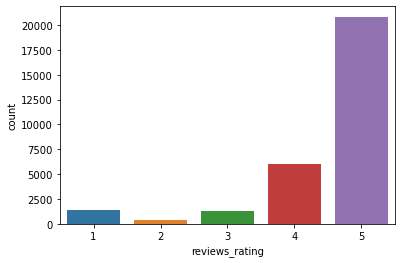

In [17]:
df_1.reviews_rating.value_counts()

sns.countplot(df_1['reviews_rating'])
plt.show()

In [18]:
#sns.countplot(df_1['reviews_date'])
#plt.show()
df_1.brand.value_counts()

Clorox                        10585
Warner Home Video              3325
Disney                         1200
L'oreal Paris                  1186
FOX                             887
                              ...  
Wilton                            1
INC International Concepts        1
Walkers                           1
Southern Enterprises              1
Bodycology                        1
Name: brand, Length: 214, dtype: int64

In [19]:
df_1.manufacturer.value_counts()

Clorox                  8546
Test                    3325
AmazonUs/CLOO7          2039
L'oreal Paris           1232
Walt Disney             1143
                        ... 
La Tortilla Fac            1
Wmu                        1
Herr's                     1
Southern Enterprises       1
Lite-Source                1
Name: manufacturer, Length: 227, dtype: int64

0


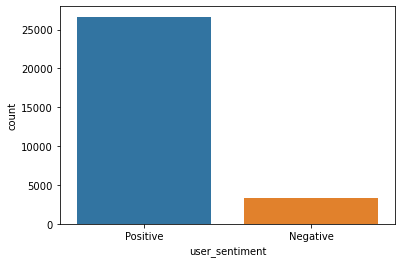

In [20]:
df_1.user_sentiment.value_counts()
df_1.user_sentiment.fillna(df_1.user_sentiment.mode()[0], inplace=True)
print (df_1.user_sentiment.isna().sum())

sns.countplot(df_1['user_sentiment'])
plt.show()

In [21]:
df_1.reviews_title.value_counts()

Great Product                  384
Great movie                    361
Clorox Wipes                   278
Great                          221
Great product                  205
                              ... 
Good, Not Fantastic              1
Rice is nice at a big price      1
cleans!                          1
movie was priced right           1
Works well!                      1
Name: reviews_title, Length: 18535, dtype: int64

In [22]:
df_1.reviews_title.isna().sum()

190

In [23]:
det = df_1[['reviews_text', 'user_sentiment']]
det.head()

,reviews_text,user_sentiment
0,i love this album. it's very good. more to the...,Positive
1,Good flavor. This review was collected as part...,Positive
2,Good flavor.,Positive
3,I read through the reviews on here before look...,Negative
4,My husband bought this gel for us. The gel cau...,Negative


In [24]:
## combingin the reveiews_title & reviews_text as they contain useful text data.
det["review_title_text"] = df_1["reviews_title"] + " " + df_1["reviews_text"]
det.head()

,reviews_text,user_sentiment,review_title_text
0,i love this album. it's very good. more to the...,Positive,Just Awesome i love this album. it's very good...
1,Good flavor. This review was collected as part...,Positive,Good Good flavor. This review was collected as...
2,Good flavor.,Positive,Good Good flavor.
3,I read through the reviews on here before look...,Negative,Disappointed I read through the reviews on her...
4,My husband bought this gel for us. The gel cau...,Negative,Irritation My husband bought this gel for us. ...


In [25]:
## converting the user_sentiment to numerical value
det['user_sentiment'] = det['user_sentiment'].apply(lambda x:1 if x == 'Positive' else 0)

In [26]:
det.drop('reviews_text', axis='columns', inplace=True)
det.head()

,user_sentiment,review_title_text
0,1,Just Awesome i love this album. it's very good...
1,1,Good Good flavor. This review was collected as...
2,1,Good Good flavor.
3,0,Disappointed I read through the reviews on her...
4,0,Irritation My husband bought this gel for us. ...


In [27]:
X = det['review_title_text']
y = det['user_sentiment']

# Text processing

Removing special characters, 
Removing multiple spaces, 
Removing digits, 
converting to lowercase, 
Lemmatization, 

In [29]:
documents = []

from nltk.stem import WordNetLemmatizer

stemmer = WordNetLemmatizer()

for sen in range(0, len(X)):
    # Remove all the special characters
    document = re.sub(r'\W', ' ', str(X[sen]))
    
    # remove all single characters
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)
    
    # Remove single characters from the start
    document = re.sub(r'\^[a-zA-Z]\s+', ' ', document) 
    
    # Substituting multiple spaces with single space
    document = re.sub(r'\s+', ' ', document, flags=re.I)
    
    # Removing digits
    # using join and isdigit 
    # to remove numeric digits from string
    document = ''.join([i for i in document if not i.isdigit()])
    #document = re.sub(r'^b\s+', '', document)
    
    # Converting to Lowercase
    document = document.lower()
    
    # Lemmatization
    document = document.split()

    document = [stemmer.lemmatize(word) for word in document]
    document = ' '.join(document)
    
    documents.append(document)

In [30]:
#from textblob import TextBlob

#documents_SC = []

#for i in documents:
    #textBlb = TextBlob(i)
    #corrected = textBlb.correct()
    #documents_SC.append(i)
    

In [31]:
def accuracy_metrics(predict,actual):

    #confusion matrix
    conf_matrix_train = confusion_matrix(predict.round(),actual)
    fig, ax = plt.subplots(figsize=(5,4))
    heatmap=sns.heatmap(conf_matrix_train,annot=True,fmt="d",
                    xticklabels=['Non Churn', 'Churn'],yticklabels=['Non Churn', 'Churn'])
    ax.set_ylim([0,2])
    plt.ylabel('Actual ')
    plt.xlabel('Predicted ')
    plt.show()

    #F-1score, accuracy, precision,recall
    print('Classification Report is \n')
    print(classification_report(predict.round(),actual))

    #Area under the curve (AUC)
    model_roc_auc = roc_auc_score(predict.round(),actual) 
    print ("Area under curve : ",round(model_roc_auc,3),"\n")

# CountVectorizer & TFIDF Converter

In [32]:
vectorizer = CountVectorizer(max_features=1500, min_df=5, max_df=0.7, stop_words=stopwords.words('english'))
X = vectorizer.fit_transform(documents).toarray()

In [33]:
tfidfconverter = TfidfTransformer()
X = tfidfconverter.fit_transform(X).toarray()

In [34]:
tfidfconverter = TfidfVectorizer(max_features=1500, min_df=5, max_df=0.7, stop_words=stopwords.words('english'))
X = tfidfconverter.fit_transform(documents).toarray()

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# There is huge imbalance, using SMOTE to fix the imabalance

In [36]:
counter = Counter(y_train)
print ('Before', counter)
smt = SMOTE()
X_train_new, Y_train_new = smt.fit_resample(X_train, y_train)
counter_new = Counter(Y_train_new)
print ('After', counter_new)

Before Counter({1: 21258, 0: 2742})
After Counter({1: 21258, 0: 21258})


In [40]:
def elapsed_time(start, end):
    temp = end - start
    hours = temp//3600
    temp = temp - 3600*hours
    minutes = temp//60
    seconds = temp - 60*minutes
    return (hours, minutes, seconds)

# Model building & Evaluation

#### Random Forest

In [42]:
start_time = time.time()

RFclassifier = RandomForestClassifier(n_estimators=1000, random_state=0)
RFclassifier.fit(X_train_new, Y_train_new) 

#end_time = time.time() - start_time
temp = time.time() - start_time
hours = temp//3600
temp = temp - 3600*hours
minutes = temp//60
seconds = temp - 60*minutes
print('%d:%d:%d' %(hours,minutes,seconds))

0:12:45


In [43]:
y_pred = RFclassifier.predict(X_test)

 Train data accuracy metrics are 


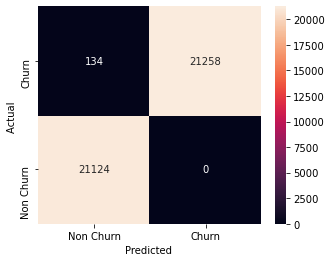

Classification Report is 

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     21124
           1       1.00      0.99      1.00     21392

    accuracy                           1.00     42516
   macro avg       1.00      1.00      1.00     42516
weighted avg       1.00      1.00      1.00     42516

Area under curve :  0.997 

##################################################
 Test data accuracy metrics are 


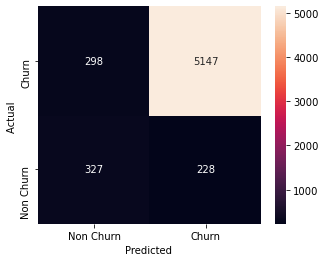

Classification Report is 

              precision    recall  f1-score   support

           0       0.52      0.59      0.55       555
           1       0.96      0.95      0.95      5445

    accuracy                           0.91      6000
   macro avg       0.74      0.77      0.75      6000
weighted avg       0.92      0.91      0.91      6000

Area under curve :  0.767 



In [44]:
y_pred_train=RFclassifier.predict(X_train_new)

#fitting logistic model on the test dataset
y_pred_test=RFclassifier.predict(X_test)

#training dataset
print(' Train data accuracy metrics are ')
accuracy_metrics(y_pred_train,Y_train_new)

#testing dataset
print('##################################################')
print(' Test data accuracy metrics are ')
accuracy_metrics(y_pred_test,y_test)

In [45]:
import joblib
joblib.dump(RFclassifier, "model-RF.pkl")

['model-RF.pkl']

#### Deicision Tree 

In [46]:
start_time = time.time()

from sklearn.tree import DecisionTreeClassifier

dec_tree = DecisionTreeClassifier(criterion='entropy',\
                                  max_depth=5,
                                 min_samples_split=5,
                                 min_samples_leaf=5)
dec_tree.fit(X_train_new, Y_train_new)

### elapsed_time = time.time() - start_time
temp = time.time() - start_time
hours = temp//3600
temp = temp - 3600*hours
minutes = temp//60
seconds = temp - 60*minutes
print('%d:%d:%d' %(hours,minutes,seconds))

0:0:6


In [47]:
y_pred = dec_tree.predict(X_test)

 Train data accuracy metrics are 


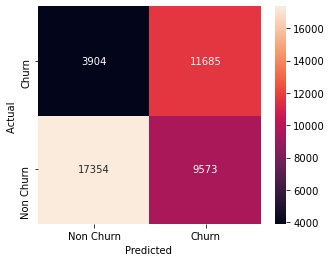

Classification Report is 

              precision    recall  f1-score   support

           0       0.82      0.64      0.72     26927
           1       0.55      0.75      0.63     15589

    accuracy                           0.68     42516
   macro avg       0.68      0.70      0.68     42516
weighted avg       0.72      0.68      0.69     42516

Area under curve :  0.697 

##################################################
 Test data accuracy metrics are 


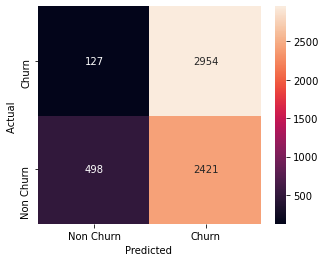

Classification Report is 

              precision    recall  f1-score   support

           0       0.80      0.17      0.28      2919
           1       0.55      0.96      0.70      3081

    accuracy                           0.58      6000
   macro avg       0.67      0.56      0.49      6000
weighted avg       0.67      0.58      0.50      6000

Area under curve :  0.565 



In [48]:
y_pred_train=dec_tree.predict(X_train_new)

#fitting logistic model on the test dataset
y_pred_test=dec_tree.predict(X_test)

#training dataset
print(' Train data accuracy metrics are ')
accuracy_metrics(y_pred_train,Y_train_new)

#testing dataset
print('##################################################')
print(' Test data accuracy metrics are ')
accuracy_metrics(y_pred_test,y_test)

In [49]:
joblib.dump(dec_tree, "model-DecisionTree.pkl")

['model-DecisionTree.pkl']

#### XG Boost 

In [50]:
start_time = time.time()

XG_model_default = XGBClassifier()
XG_model_default.fit(X_train_new, Y_train_new)

### elapsed_time = time.time() - start_time


XGBClassifier()

 Train data accuracy metrics are 


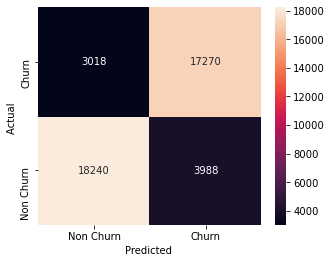

Classification Report is 

              precision    recall  f1-score   support

           0       0.86      0.82      0.84     22228
           1       0.81      0.85      0.83     20288

    accuracy                           0.84     42516
   macro avg       0.84      0.84      0.84     42516
weighted avg       0.84      0.84      0.84     42516

Area under curve :  0.836 

##################################################
 Test data accuracy metrics are 


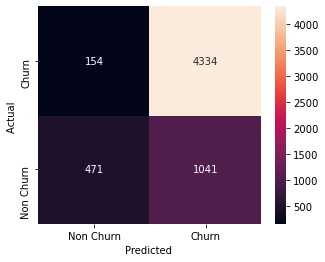

Classification Report is 

              precision    recall  f1-score   support

           0       0.75      0.31      0.44      1512
           1       0.81      0.97      0.88      4488

    accuracy                           0.80      6000
   macro avg       0.78      0.64      0.66      6000
weighted avg       0.79      0.80      0.77      6000

Area under curve :  0.639 



In [51]:
y_pred_train=XG_model_default.predict(X_train_new)

#fitting logistic model on the test dataset
y_pred_test=XG_model_default.predict(X_test)

#training dataset
print(' Train data accuracy metrics are ')
accuracy_metrics(y_pred_train,Y_train_new)

#testing dataset
print('##################################################')
print(' Test data accuracy metrics are ')
accuracy_metrics(y_pred_test,y_test)

In [52]:
joblib.dump(XG_model_default, "model-XGBoost.pkl")

['model-XGBoost.pkl']

#### Naive Bayes

In [53]:
start_time = time.time()

gnb = GaussianNB()
gnb.fit(X_train_new, Y_train_new)

### elapsed_time = time.time() - start_time
temp = time.time() - start_time
hours = temp//3600
temp = temp - 3600*hours
minutes = temp//60
seconds = temp - 60*minutes
print('%d:%d:%d' %(hours,minutes,seconds))

0:0:1


 Train data accuracy metrics are 


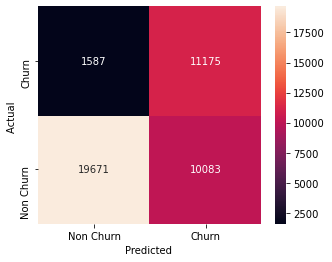

Classification Report is 

              precision    recall  f1-score   support

           0       0.93      0.66      0.77     29754
           1       0.53      0.88      0.66     12762

    accuracy                           0.73     42516
   macro avg       0.73      0.77      0.71     42516
weighted avg       0.81      0.73      0.74     42516

Area under curve :  0.768 

##################################################
 Test data accuracy metrics are 


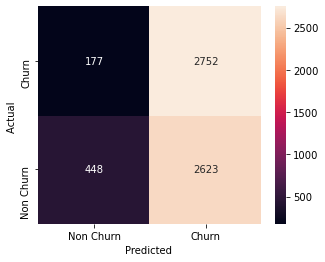

Classification Report is 

              precision    recall  f1-score   support

           0       0.72      0.15      0.24      3071
           1       0.51      0.94      0.66      2929

    accuracy                           0.53      6000
   macro avg       0.61      0.54      0.45      6000
weighted avg       0.62      0.53      0.45      6000

Area under curve :  0.543 



In [54]:
y_pred_train=gnb.predict(X_train_new)

#fitting logistic model on the test dataset
y_pred_test=gnb.predict(X_test)

#training dataset
print(' Train data accuracy metrics are ')
accuracy_metrics(y_pred_train,Y_train_new)

#testing dataset
print('##################################################')
print(' Test data accuracy metrics are ')
accuracy_metrics(y_pred_test,y_test)

In [55]:
joblib.dump(gnb, "model-GNB.pkl")

['model-GNB.pkl']

#### Logistic Regression

In [56]:
start_time = time.time()

logreg = LogisticRegression()
logreg.fit(X_train_new, Y_train_new)

### elapsed_time = time.time() - start_time
temp = time.time() - start_time
hours = temp//3600
temp = temp - 3600*hours
minutes = temp//60
seconds = temp - 60*minutes
print('%d:%d:%d' %(hours,minutes,seconds))

0:0:8


 Train data accuracy metrics are 


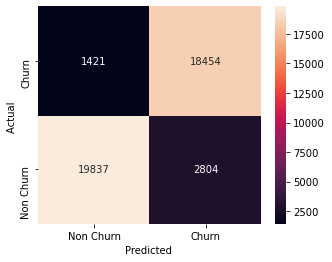

Classification Report is 

              precision    recall  f1-score   support

           0       0.93      0.88      0.90     22641
           1       0.87      0.93      0.90     19875

    accuracy                           0.90     42516
   macro avg       0.90      0.90      0.90     42516
weighted avg       0.90      0.90      0.90     42516

Area under curve :  0.902 

##################################################
 Test data accuracy metrics are 


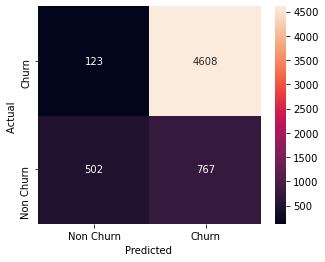

Classification Report is 

              precision    recall  f1-score   support

           0       0.80      0.40      0.53      1269
           1       0.86      0.97      0.91      4731

    accuracy                           0.85      6000
   macro avg       0.83      0.68      0.72      6000
weighted avg       0.85      0.85      0.83      6000

Area under curve :  0.685 



In [57]:
y_pred_train=logreg.predict(X_train_new)

#fitting logistic model on the test dataset
y_pred_test=logreg.predict(X_test)

#training dataset
print(' Train data accuracy metrics are ')
accuracy_metrics(y_pred_train,Y_train_new)

#testing dataset
print('##################################################')
print(' Test data accuracy metrics are ')
accuracy_metrics(y_pred_test,y_test)

In [58]:
joblib.dump(logreg, "model-LR.pkl")

['model-LR.pkl']

In [59]:
from sklearn import metrics

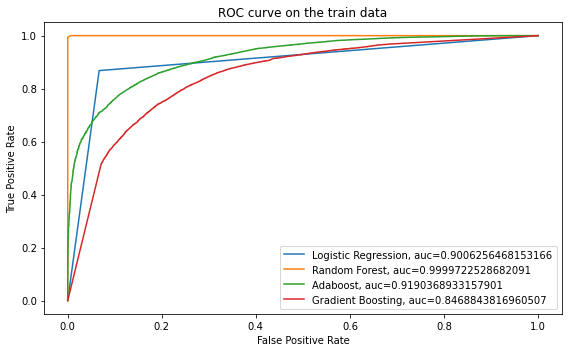

In [60]:
## Comparison of classification models
## AUC provides an aggregate measure of performance across all possible classification thresholds

plt.figure(figsize=(8,5),num=1).clf()
#Logistic Regression
y_pred_train = np.array(logreg.predict(X_train_new))
fpr, tpr, _ = metrics.roc_curve(Y_train_new,  y_pred_train)
auc = metrics.roc_auc_score(Y_train_new,  y_pred_train)
plt.plot(fpr,tpr,label="Logistic Regression, auc="+str(auc))


#Random Forest Classifier
y_pred_train= RFclassifier.predict_proba(X_train_new)[::,1]
fpr, tpr, _ = metrics.roc_curve(Y_train_new,  y_pred_train)
auc = metrics.roc_auc_score(Y_train_new, y_pred_train)
plt.plot(fpr,tpr,label="Random Forest, auc="+str(auc))
plt.legend(loc=4)

#XG Boost Classifier
y_pred_train= XG_model_default.predict_proba(X_train_new)[::,1]
fpr, tpr, _ = metrics.roc_curve(Y_train_new,  y_pred_train)
auc = metrics.roc_auc_score(Y_train_new, y_pred_train)
plt.plot(fpr,tpr,label="Adaboost, auc="+str(auc))
plt.legend(loc=4)
         
#Naive Bayes  Classifier
y_pred_train= gnb.predict_proba(X_train_new)[::,1]
fpr, tpr, _ = metrics.roc_curve(Y_train_new,  y_pred_train)
auc = metrics.roc_auc_score(Y_train_new, y_pred_train)
plt.plot(fpr,tpr,label="Gradient Boosting, auc="+str(auc))
plt.legend(loc=4)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve on the train data')
plt.tight_layout()

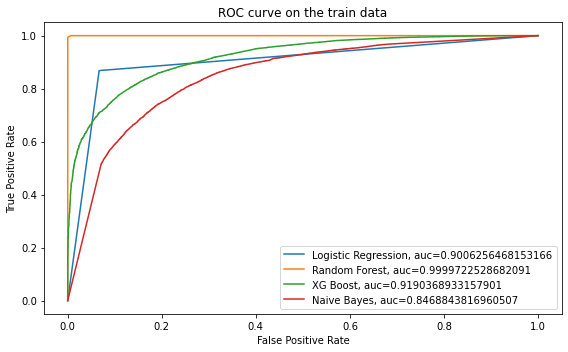

In [61]:
## Comparison of classification models
## AUC provides an aggregate measure of performance across all possible classification thresholds

plt.figure(figsize=(8,5),num=1).clf()
#Logistic Regression
y_pred_train = np.array(logreg.predict(X_train_new))
fpr, tpr, _ = metrics.roc_curve(Y_train_new,  y_pred_train)
auc = metrics.roc_auc_score(Y_train_new,  y_pred_train)
plt.plot(fpr,tpr,label="Logistic Regression, auc="+str(auc))


#Random Forest Classifier
y_pred_train= RFclassifier.predict_proba(X_train_new)[::,1]
fpr, tpr, _ = metrics.roc_curve(Y_train_new,  y_pred_train)
auc = metrics.roc_auc_score(Y_train_new, y_pred_train)
plt.plot(fpr,tpr,label="Random Forest, auc="+str(auc))
plt.legend(loc=4)

#XG Boost Classifier
y_pred_train= XG_model_default.predict_proba(X_train_new)[::,1]
fpr, tpr, _ = metrics.roc_curve(Y_train_new,  y_pred_train)
auc = metrics.roc_auc_score(Y_train_new, y_pred_train)
plt.plot(fpr,tpr,label="XG Boost, auc="+str(auc))
plt.legend(loc=4)
         
#Naive Bayes  Classifier
y_pred_train= gnb.predict_proba(X_train_new)[::,1]
fpr, tpr, _ = metrics.roc_curve(Y_train_new,  y_pred_train)
auc = metrics.roc_auc_score(Y_train_new, y_pred_train)
plt.plot(fpr,tpr,label="Naive Bayes, auc="+str(auc))
plt.legend(loc=4)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve on the train data')
plt.tight_layout()

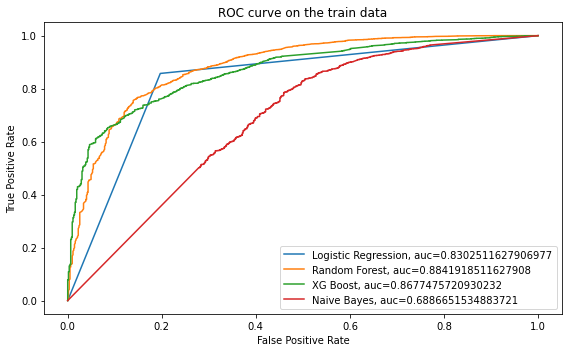

In [62]:
plt.figure(figsize=(8,5),num=1).clf()
#Logistic Regression
y_pred_test = np.array(logreg.predict(X_test))
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_test)
auc = metrics.roc_auc_score(y_test,  y_pred_test)
plt.plot(fpr,tpr,label="Logistic Regression, auc="+str(auc))


#Random Forest Classifier
y_pred_test= RFclassifier.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_test)
auc = metrics.roc_auc_score(y_test, y_pred_test)
plt.plot(fpr,tpr,label="Random Forest, auc="+str(auc))
plt.legend(loc=4)

#XG Boost Classifier
y_pred_test= XG_model_default.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_test)
auc = metrics.roc_auc_score(y_test, y_pred_test)
plt.plot(fpr,tpr,label="XG Boost, auc="+str(auc))
plt.legend(loc=4)
         
#Naive Bayes  Classifier
y_pred_test= gnb.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_test)
auc = metrics.roc_auc_score(y_test, y_pred_test)
plt.plot(fpr,tpr,label="Naive Bayes, auc="+str(auc))
plt.legend(loc=4)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve on the train data')
plt.tight_layout()

# Recommendation Engine

In [6]:
df_org = pd.read_csv("sample30.csv")

In [40]:
det = df_org[['id', 'reviews_rating', 'reviews_username']]

In [41]:
det.head()

,id,reviews_rating,reviews_username
0,AV13O1A8GV-KLJ3akUyj,5,joshua
1,AV14LG0R-jtxr-f38QfS,5,dorothy w
2,AV14LG0R-jtxr-f38QfS,5,dorothy w
3,AV16khLE-jtxr-f38VFn,1,rebecca
4,AV16khLE-jtxr-f38VFn,1,walker557


In [42]:
det.dropna(inplace=True)

In [43]:
# Test and Train split of the dataset.
from sklearn.model_selection import train_test_split
train, test = train_test_split(det, test_size=0.30, random_state=31)

In [44]:
print(train.shape)
print(test.shape)

(20955, 3)
(8982, 3)


In [45]:
train.head()

,id,reviews_rating,reviews_username
5704,AVpf2tw1ilAPnD_xjflC,4,dwof
12549,AVpf3VOfilAPnD_xjpun,5,josie225
8534,AVpf3VOfilAPnD_xjpun,5,mellin1
5671,AVpf2tw1ilAPnD_xjflC,4,jerry64gd
21698,AVpfm8yiLJeJML43AYyu,1,augale


In [46]:
# Pivot the train ratings' dataset into matrix format in which columns are movies and the rows are user IDs.
df_pivot = train.pivot_table(
    index='reviews_username',
    columns='id',
    values='reviews_rating'
).fillna(0)

df_pivot.head(3)

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,...,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01impala,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02dakota,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [47]:
# Copy the train dataset into dummy_train
dummy_train = train.copy()

In [48]:
dummy_train.head()

,id,reviews_rating,reviews_username
5704,AVpf2tw1ilAPnD_xjflC,4,dwof
12549,AVpf3VOfilAPnD_xjpun,5,josie225
8534,AVpf3VOfilAPnD_xjpun,5,mellin1
5671,AVpf2tw1ilAPnD_xjflC,4,jerry64gd
21698,AVpfm8yiLJeJML43AYyu,1,augale


In [49]:
dummy_train['reviews_rating'] = dummy_train['reviews_rating'].apply(lambda x: 0 if x>=1 else 1)

In [50]:
# Convert the dummy train dataset into matrix format.
dummy_train = dummy_train.pivot_table(
    index='reviews_username',
    columns='id',
    values='reviews_rating'
).fillna(1)

In [51]:
dummy_train.head()

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,...,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
01impala,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
02dakota,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
02deuce,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
06stidriver,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [76]:
df_pivot.index.nunique()

18212

In [77]:
from sklearn.metrics.pairwise import pairwise_distances

# Creating the User Similarity Matrix using pairwise_distance function.
user_correlation = 1 - pairwise_distances(df_pivot, metric='cosine')
user_correlation[np.isnan(user_correlation)] = 0
print(user_correlation)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 1. 1.]]


In [78]:
user_correlation.shape

(18212, 18212)

In [79]:
# Create a user-movie matrix.
df_pivot = train.pivot_table(
    index='reviews_username',
    columns='id',
    values='reviews_rating'
)

In [80]:
df_pivot.head()

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,...,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
01impala,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02dakota,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02deuce,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
06stidriver,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [81]:
mean = np.nanmean(df_pivot, axis=1)
df_subtracted = (df_pivot.T-mean).T

In [82]:
df_subtracted.head()

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,...,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
01impala,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02dakota,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02deuce,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
06stidriver,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [83]:
from sklearn.metrics.pairwise import pairwise_distances

In [85]:
# Creating the User Similarity Matrix using pairwise_distance function.
user_correlation = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
user_correlation[np.isnan(user_correlation)] = 0
print(user_correlation)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [86]:
user_correlation.shape

(18212, 18212)

In [87]:
user_correlation[user_correlation<0]=0
user_correlation

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [88]:
user_predicted_ratings = np.dot(user_correlation, df_pivot.fillna(0))
user_predicted_ratings

array([[0.        , 0.        , 0.        , ..., 1.55829543, 3.20256308,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [89]:
user_predicted_ratings.shape

(18212, 255)

In [90]:
user_predicted_ratings

array([[0.        , 0.        , 0.        , ..., 1.55829543, 3.20256308,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [91]:
user_final_rating = np.multiply(user_predicted_ratings,dummy_train)
user_final_rating.head()

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,...,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,0.0,0.0,0.0,6.059436,0.0,0.0,0.0,0.915079,0.0,0.0,...,0.545545,0.0,0.0,0.0,0.0,0.0,0.0,1.558295,3.202563,0.0
01impala,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
02dakota,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
02deuce,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
06stidriver,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0


In [92]:
user_predicted_ratings.shape

(18212, 255)

In [95]:
# Take the user ID as input.
user_input = input("Enter your user name")
print(user_input)

Enter your user namecassie
cassie


In [96]:
d = user_final_rating.loc[user_input].sort_values(ascending=False)[0:20]
d

id
AVpf0eb2LJeJML43EVSt    4.500000
AVpe31o71cnluZ0-YrSD    2.886751
AVpf0thK1cnluZ0-r8vR    2.886751
AV1Ymf_rglJLPUi8II2v    2.665009
AVpfov9TLJeJML43A7B0    2.665009
AVpe59io1cnluZ0-ZgDU    2.567524
AVpf385g1cnluZ0-s0_t    2.132007
AVpe41TqilAPnD_xQH3d    1.520545
AVpfPaoqLJeJML435Xk9    1.240640
AVpfJP1C1cnluZ0-e3Xy    1.020621
AVpf3VOfilAPnD_xjpun    1.020621
AVpfBO2vLJeJML430mGh    0.816497
AV1Ys0kTvKc47QAVgx1C    0.096462
AVpf5olc1cnluZ0-tPrO    0.096462
AVpfUN2nilAPnD_xZeY3    0.096462
AV1YtGjdglJLPUi8IOfJ    0.096462
AVpfCuzrilAPnD_xTroT    0.096462
AVpfPnrU1cnluZ0-g9rL    0.096462
AVpfRTh1ilAPnD_xYic2    0.096462
AVpfD9xTLJeJML431ig2    0.096462
Name: cassie, dtype: float64

In [97]:
d = pd.merge(d,df_org,left_on='id',right_on='id', how = 'left')

In [98]:
len(d)

18667

In [99]:
d["review_title_text"] = d["reviews_title"] + d["reviews_text"]

In [100]:
import joblib

RandFclassifer = joblib.load("model-RF.pkl")

In [101]:
X = d['review_title_text']

In [102]:
documents = []

from nltk.stem import WordNetLemmatizer

stemmer = WordNetLemmatizer()
#sym_spell = SpellChecker()

for sen in range(0, len(X)):
    
    
    # Remove all the special characters
    document = re.sub(r'\W', ' ', str(X[sen]))
    
    # remove all single characters
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)
    
    # Remove single characters from the start
    document = re.sub(r'\^[a-zA-Z]\s+', ' ', document) 
    
    # Substituting multiple spaces with single space
    document = re.sub(r'\s+', ' ', document, flags=re.I)
    
    # Removing prefixed 'b'
    document = re.sub(r'^b\s+', '', document)
    
    # Converting to Lowercase
    document = document.lower()
    
    # Lemmatization
    document = document.split()
    

    
    #lemmatization
    document = [stemmer.lemmatize(word) for word in document]
    document = ' '.join(document)
    
    documents.append(document)

In [103]:
vectorizer = CountVectorizer(max_features=1500, min_df=5, max_df=0.7, stop_words=stopwords.words('english'))
X = vectorizer.fit_transform(documents).toarray()

In [104]:
tfidfconverter = TfidfTransformer()
X = tfidfconverter.fit_transform(X).toarray()

In [105]:
tfidfconverter = TfidfVectorizer(max_features=1500, min_df=5, max_df=0.7, stop_words=stopwords.words('english'))
X = tfidfconverter.fit_transform(documents).toarray()

In [106]:
X.shape

(18667, 1500)

In [107]:
y_sent=RandFclassifer.predict(X)

In [108]:
d['sent_pred']=y_sent

In [109]:
def get_first_val(group):
    total_reviews=len(group.sent_pred)
    total_1s=(group['sent_pred'] == 1).sum()
    postive_pre=((total_1s*100)/total_reviews)
    return(postive_pre)


final_list= d.groupby('id').apply(get_first_val).dropna()
final_list.sort_values(ascending=[False])

id
AVpfPnrU1cnluZ0-g9rL    61.827957
AVpe59io1cnluZ0-ZgDU    60.179641
AVpfPaoqLJeJML435Xk9    53.503759
AVpfD9xTLJeJML431ig2    51.538462
AVpe41TqilAPnD_xQH3d    49.537649
AVpf0eb2LJeJML43EVSt    48.402367
AVpf0thK1cnluZ0-r8vR    46.043165
AVpf385g1cnluZ0-s0_t    45.408163
AVpfRTh1ilAPnD_xYic2    41.294838
AVpe31o71cnluZ0-YrSD    40.890688
AV1YtGjdglJLPUi8IOfJ    40.277778
AVpfJP1C1cnluZ0-e3Xy    36.684649
AVpf3VOfilAPnD_xjpun    35.646577
AV1Ys0kTvKc47QAVgx1C    30.000000
AVpfov9TLJeJML43A7B0    25.773196
AVpf5olc1cnluZ0-tPrO    25.423729
AVpfCuzrilAPnD_xTroT    23.809524
AV1Ymf_rglJLPUi8II2v    23.529412
AVpfUN2nilAPnD_xZeY3    12.500000
AVpfBO2vLJeJML430mGh     0.000000
dtype: float64

In [110]:
final_list.index.tolist()

['AV1Ymf_rglJLPUi8II2v',
 'AV1Ys0kTvKc47QAVgx1C',
 'AV1YtGjdglJLPUi8IOfJ',
 'AVpe31o71cnluZ0-YrSD',
 'AVpe41TqilAPnD_xQH3d',
 'AVpe59io1cnluZ0-ZgDU',
 'AVpf0eb2LJeJML43EVSt',
 'AVpf0thK1cnluZ0-r8vR',
 'AVpf385g1cnluZ0-s0_t',
 'AVpf3VOfilAPnD_xjpun',
 'AVpf5olc1cnluZ0-tPrO',
 'AVpfBO2vLJeJML430mGh',
 'AVpfCuzrilAPnD_xTroT',
 'AVpfD9xTLJeJML431ig2',
 'AVpfJP1C1cnluZ0-e3Xy',
 'AVpfPaoqLJeJML435Xk9',
 'AVpfPnrU1cnluZ0-g9rL',
 'AVpfRTh1ilAPnD_xYic2',
 'AVpfUN2nilAPnD_xZeY3',
 'AVpfov9TLJeJML43A7B0']

# Evaluation - User User

In [115]:
# Find out the common users of test and train dataset.
common = test[test.reviews_username.isin(train.reviews_username)]
common.shape

(1976, 3)

In [116]:
common.head()

,id,reviews_rating,reviews_username
21169,AVpfm8yiLJeJML43AYyu,1,jjjj
8538,AVpf3VOfilAPnD_xjpun,5,jygibri
18735,AVpfJP1C1cnluZ0-e3Xy,4,jel08
22417,AVpfOmKwLJeJML435GM7,1,elena79
19297,AVpfJP1C1cnluZ0-e3Xy,5,angc


In [117]:
common_user_based_matrix = common.pivot_table(index='reviews_username', columns='id', values='reviews_rating')

In [118]:
common_user_based_matrix.head()

id,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YneDPglJLPUi8IJyQ,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,AV1h6Gu0glJLPUi8IjA_,...,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfpM2yilAPnD_xfmDG,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfs0tUilAPnD_xgqN2,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,
1234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
123charlie,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
37f5p,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4cloroxl,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50cal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [119]:
# Convert the user_correlation matrix into dataframe.
user_correlation_df = pd.DataFrame(user_correlation)

In [120]:
user_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,...,18202,18203,18204,18205,18206,18207,18208,18209,18210,18211
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [121]:
df_subtracted.head(1)

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,...,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [122]:
user_correlation_df['reviews_username'] = df_subtracted.index

user_correlation_df.set_index('reviews_username',inplace=True)
user_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,...,18202,18203,18204,18205,18206,18207,18208,18209,18210,18211
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01impala,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02dakota,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02deuce,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
06stidriver,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [123]:
common.head(1)

,id,reviews_rating,reviews_username
21169,AVpfm8yiLJeJML43AYyu,1,jjjj


In [124]:
list_name = common.reviews_username.tolist()

user_correlation_df.columns = df_subtracted.index.tolist()


user_correlation_df_1 =  user_correlation_df[user_correlation_df.index.isin(list_name)]

In [125]:
user_correlation_df_1.shape

(1660, 18212)

In [126]:
user_correlation_df_2 = user_correlation_df_1.T[user_correlation_df_1.T.index.isin(list_name)]

In [127]:
user_correlation_df_3 = user_correlation_df_2.T

In [128]:
user_correlation_df_3.head()

,1234,123charlie,37f5p,4cloroxl,50cal,7.87E+11,aac06002,abbey,abbi,abby,...,yesseniaw22,yeya,ygtz,yummy,zapman,zburt5,zebras,zippy,zitro,zxcsdfd
reviews_username,,,,,,,,,,,,,,,,,,,,,
1234,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
123charlie,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37f5p,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4cloroxl,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50cal,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [129]:
user_correlation_df_3.shape

(1660, 1660)

In [130]:
user_correlation_df_3[user_correlation_df_3<0]=0

common_user_predicted_ratings = np.dot(user_correlation_df_3, common_user_based_matrix.fillna(0))
common_user_predicted_ratings

array([[0.28867513, 0.        , 0.        , ..., 2.5423759 , 1.44337567,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [131]:
dummy_test = common.copy()
dummy_test['reviews_rating'] = dummy_test['reviews_rating'].apply(lambda x: 1 if x>=1 else 0)
dummy_test = dummy_test.pivot_table(index='reviews_username', columns='id', values='reviews_rating').fillna(0)

In [132]:
dummy_test.shape

(1660, 127)

In [133]:
common_user_based_matrix.head()

id,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YneDPglJLPUi8IJyQ,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,AV1h6Gu0glJLPUi8IjA_,...,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfpM2yilAPnD_xfmDG,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfs0tUilAPnD_xgqN2,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,
1234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
123charlie,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
37f5p,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4cloroxl,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50cal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [134]:
dummy_test.head()

id,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YneDPglJLPUi8IJyQ,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,AV1h6Gu0glJLPUi8IjA_,...,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfpM2yilAPnD_xfmDG,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfs0tUilAPnD_xgqN2,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,
1234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
123charlie,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37f5p,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4cloroxl,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50cal,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [135]:
common_user_predicted_ratings = np.multiply(common_user_predicted_ratings,dummy_test)

In [136]:
common_user_predicted_ratings.head()

id,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YneDPglJLPUi8IJyQ,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,AV1h6Gu0glJLPUi8IjA_,...,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfpM2yilAPnD_xfmDG,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfs0tUilAPnD_xgqN2,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,
1234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
123charlie,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37f5p,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4cloroxl,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50cal,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [137]:
from sklearn.preprocessing import MinMaxScaler
from numpy import *

X  = common_user_predicted_ratings.copy() 
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

MinMaxScaler(feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [138]:
common_ = common.pivot_table(index='reviews_username', columns='id', values='reviews_rating')

In [139]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))

In [140]:
rmse = (sum(sum((common_ - y )**2))/total_non_nan)**0.5
print(rmse)

2.4124916499091618


# Item based Similarity

In [52]:
df_pivot = train.pivot_table(
    index='reviews_username',
    columns='id',
    values='reviews_rating'
).T

df_pivot.head()

reviews_username,00sab00,01impala,02dakota,02deuce,06stidriver,08dallas,09mommy11,1.11E+24,1085,10ten,...,zowie,zozo0o,zpalma,zsazsa,zt313,zuttle,zwithanx,zxcsdfd,zyiah4,zzz1127
id,,,,,,,,,,,,,,,,,,,,,
AV13O1A8GV-KLJ3akUyj,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV14LG0R-jtxr-f38QfS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV16khLE-jtxr-f38VFn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YGDqsGV-KLJ3adc-O,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YIch7GV-KLJ3addeG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [53]:
mean = np.nanmean(df_pivot, axis=1)
df_subtracted = (df_pivot.T-mean).T

In [54]:
df_subtracted.head(3)

reviews_username,00sab00,01impala,02dakota,02deuce,06stidriver,08dallas,09mommy11,1.11E+24,1085,10ten,...,zowie,zozo0o,zpalma,zsazsa,zt313,zuttle,zwithanx,zxcsdfd,zyiah4,zzz1127
id,,,,,,,,,,,,,,,,,,,,,
AV13O1A8GV-KLJ3akUyj,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV14LG0R-jtxr-f38QfS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV16khLE-jtxr-f38VFn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [55]:
# Item Similarity Matrix
item_correlation = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
item_correlation[np.isnan(item_correlation)] = 0
print(item_correlation)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


In [56]:
item_correlation.shape

(255, 255)

In [57]:
item_correlation[item_correlation<0]=0
item_correlation

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

Prediction

In [58]:
item_predicted_ratings = np.dot((df_pivot.fillna(0).T),item_correlation)
item_predicted_ratings

array([[0.        , 0.        , 0.        , ..., 0.00600224, 0.06201728,
        0.        ],
       [0.        , 0.        , 0.01254045, ..., 0.00108461, 0.        ,
        0.        ],
       [0.        , 0.        , 0.02090075, ..., 0.00180769, 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.00644332],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.00644332],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.00515466]])

In [59]:
item_predicted_ratings.shape

(18212, 255)

In [60]:
dummy_train.shape

(18212, 255)

In [61]:
item_final_rating = np.multiply(item_predicted_ratings,dummy_train)
item_final_rating.head()

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,...,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.011345,0.001677,0.0,0.010336,0.0,0.0,0.033075,0.006002,0.062017,0.000000
01impala,0.0,0.0,0.012540,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.004564,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.001085,0.000000,0.000000
02dakota,0.0,0.0,0.020901,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.007607,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.001808,0.000000,0.000000
02deuce,0.0,0.0,0.016721,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.006085,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.001446,0.000000,0.000000
06stidriver,0.0,0.0,0.000000,0.000454,0.0,0.0,0.0,0.001731,0.001915,0.000000,...,0.000000,0.000000,0.0,0.003187,0.0,0.0,0.000000,0.000000,0.000000,0.006443


In [62]:
# Take the user ID as input
user_input = input("Enter your user name")
print(user_input)

Enter your user namecassie
cassie


In [63]:
# Recommending the Top 5 products to the user.
d = item_final_rating.loc[user_input].sort_values(ascending=False)[0:20]
d

id
AVpfE7puilAPnD_xUcCW    0.269623
AVpfNc9cLJeJML434tza    0.059663
AVpfJcHuLJeJML433ZrY    0.056327
AVpe4hlXLJeJML43xbrB    0.032075
AVpf385g1cnluZ0-s0_t    0.016901
AVpe8gsILJeJML43y6Ed    0.016090
AVpfNWbPilAPnD_xXPR7    0.014848
AVpfPaoqLJeJML435Xk9    0.012128
AVpe41TqilAPnD_xQH3d    0.009563
AVpfN6Z71cnluZ0-gZmO    0.007916
AV1YGDqsGV-KLJ3adc-O    0.006266
AVpfAgSp1cnluZ0-b2-K    0.006262
AVpfRTh1ilAPnD_xYic2    0.005617
AVpfJP1C1cnluZ0-e3Xy    0.005128
AVpf2tw1ilAPnD_xjflC    0.004635
AVpe59io1cnluZ0-ZgDU    0.004561
AVpf4oLxLJeJML43FcxC    0.003653
AVpf63aJLJeJML43F__Q    0.002689
AVpf3VOfilAPnD_xjpun    0.001530
AVpf-lMV1cnluZ0-ub0_    0.000000
Name: cassie, dtype: float64

In [64]:
d = pd.merge(d,df_org,left_on='id',right_on='id',how = 'left')
d.head()

,id,cassie,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
0,AVpfE7puilAPnD_xUcCW,0.269623,South Shore,"Furniture,Bedroom Furniture,Nightstands,Home,H...",South Shore,Bilbao Nightstand Gray Oak - South Shore,2014-12-20T00:00:00Z,NaN,NaN,1,1) This product was missing pieces. Not screws...,Horrible construction,NaN,NaN,mike,Positive
1,AVpfE7puilAPnD_xUcCW,0.269623,South Shore,"Furniture,Bedroom Furniture,Nightstands,Home,H...",South Shore,Bilbao Nightstand Gray Oak - South Shore,2013-06-16T19:21:26.000Z,NaN,NaN,3,I believe this is meant for a kids room but I ...,It's Purrty,Minneapolis,NaN,savvy guy,Positive
2,AVpfE7puilAPnD_xUcCW,0.269623,South Shore,"Furniture,Bedroom Furniture,Nightstands,Home,H...",South Shore,Bilbao Nightstand Gray Oak - South Shore,2013-06-16T00:00:00Z,NaN,NaN,3,I believe this is meant for a kids room but I ...,It's purrty,NaN,NaN,savvyguy,Positive
3,AVpfE7puilAPnD_xUcCW,0.269623,South Shore,"Furniture,Bedroom Furniture,Nightstands,Home,H...",South Shore,Bilbao Nightstand Gray Oak - South Shore,2014-08-27T00:00:00Z,NaN,NaN,4,We bought this set after our wedding and it's ...,Beautiful when finished building,NaN,NaN,atshead,Positive
4,AVpfE7puilAPnD_xUcCW,0.269623,South Shore,"Furniture,Bedroom Furniture,Nightstands,Home,H...",South Shore,Bilbao Nightstand Gray Oak - South Shore,2014-12-03T00:00:00Z,NaN,NaN,5,"Needed a nightstand for my girlfriend, all the...",Beautiful!,NaN,NaN,javier,Positive


In [65]:
train_new = pd.merge(train,df_org,left_on='id',right_on='id',how='left')
#train_new[train_new.userId == 1] .head()

In [66]:
train_new.head(3)

,id,reviews_rating_x,reviews_username_x,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating_y,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username_y,user_sentiment
0,AVpf2tw1ilAPnD_xjflC,4,dwof,Summit Entertainment,"Movies & TV Shows,Instawatch Movies By VUDU,Sh...",Summit Entertainment,Red (special Edition) (dvdvideo),2014-01-04T00:00:00.000Z,NaN,False,2,"Overall a cute tongue in cheek comedy, with so...",Not everything ages gracefully..,NaN,NaN,nomorepaidreviews,Positive
1,AVpf2tw1ilAPnD_xjflC,4,dwof,Summit Entertainment,"Movies & TV Shows,Instawatch Movies By VUDU,Sh...",Summit Entertainment,Red (special Edition) (dvdvideo),2014-03-21T00:00:00.000Z,NaN,False,2,Bought this because it was on sale because I e...,So So movie,NaN,NaN,loki33,Positive
2,AVpf2tw1ilAPnD_xjflC,4,dwof,Summit Entertainment,"Movies & TV Shows,Instawatch Movies By VUDU,Sh...",Summit Entertainment,Red (special Edition) (dvdvideo),2015-10-29T00:00:00.000Z,NaN,False,2,its a ok movie but it was a gift for somebody ...,its a ok movie,NaN,NaN,ajrespectcosby,Positive


In [67]:
train_new.shape

(67192670, 17)

In [68]:
train_new[train_new.reviews_username_x == "cassie"] .head()

,id,reviews_rating_x,reviews_username_x,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating_y,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username_y,user_sentiment
1010307,AVpe_y-I1cnluZ0-bmvh,5,cassie,Yes to Carrots,"Personal Care,Bath, Shower & Soap,Body Wash & ...",Yes To Inc.,Yes To Carrots Nourishing Body Wash,2015-04-01T00:00:00.000Z,True,False,1,"I was not impressed with this product at all, ...",basically like the shampoo only thicker.,NaN,NaN,mayorkimbee,Positive
1010308,AVpe_y-I1cnluZ0-bmvh,5,cassie,Yes to Carrots,"Personal Care,Bath, Shower & Soap,Body Wash & ...",Yes To Inc.,Yes To Carrots Nourishing Body Wash,2013-11-12T06:00:00Z,NaN,NaN,1,I am pretty disappointed with this body wash. ...,Not Good,NaN,NaN,cinizzy,Positive
1010309,AVpe_y-I1cnluZ0-bmvh,5,cassie,Yes to Carrots,"Personal Care,Bath, Shower & Soap,Body Wash & ...",Yes To Inc.,Yes To Carrots Nourishing Body Wash,2013-02-12T00:00:00.000Z,False,False,2,I just used this for the first time. It smells...,mixed feelings,NaN,NaN,animn35,Positive
1010310,AVpe_y-I1cnluZ0-bmvh,5,cassie,Yes to Carrots,"Personal Care,Bath, Shower & Soap,Body Wash & ...",Yes To Inc.,Yes To Carrots Nourishing Body Wash,2014-02-08T00:00:00.000Z,True,False,2,The plastic is soooo dang hard on this bottle ...,need a redesign on the spout and bottle,NaN,NaN,deewill617,Positive
1010311,AVpe_y-I1cnluZ0-bmvh,5,cassie,Yes to Carrots,"Personal Care,Bath, Shower & Soap,Body Wash & ...",Yes To Inc.,Yes To Carrots Nourishing Body Wash,2015-05-28T00:00:00.000Z,True,True,3,I love treating my skin with body wash and bod...,I say YES to Yes Carrots Hydrating Shower Gel,NaN,NaN,skyler,Positive


In [69]:
test.columns

Index(['id', 'reviews_rating', 'reviews_username'], dtype='object')

In [71]:
common =  test[test.id.isin(train.id)]
common.shape

(8964, 3)

In [73]:
common.head(4)

,id,reviews_rating,reviews_username
21384,AVpfm8yiLJeJML43AYyu,1,curlyd
14483,AVpf3VOfilAPnD_xjpun,5,prip
21169,AVpfm8yiLJeJML43AYyu,1,jjjj
25411,AVpfPaoqLJeJML435Xk9,5,internetfreak69


In [74]:
common_item_based_matrix = common.pivot_table(index='reviews_username', columns='id', values='reviews_rating').T

In [75]:
common_item_based_matrix.shape

(203, 8348)

In [76]:
item_correlation_df = pd.DataFrame(item_correlation)

In [77]:
item_correlation_df.head(1)

,0,1,2,3,4,5,6,7,8,9,...,245,246,247,248,249,250,251,252,253,254
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [78]:
item_correlation_df['id'] = df_subtracted.index
item_correlation_df.set_index('id',inplace=True)
item_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,...,245,246,247,248,249,250,251,252,253,254
id,,,,,,,,,,,,,,,,,,,,,
AV13O1A8GV-KLJ3akUyj,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
AV14LG0R-jtxr-f38QfS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
AV16khLE-jtxr-f38VFn,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.013954,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
AV1YGDqsGV-KLJ3adc-O,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.078102,0.0,0.0,0.0,0.0,0.0,0.0,0.001989,0.0,0.0
AV1YIch7GV-KLJ3addeG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


In [79]:
list_name = common.id.tolist()

In [80]:
item_correlation_df.columns = df_subtracted.index.tolist()

item_correlation_df_1 =  item_correlation_df[item_correlation_df.index.isin(list_name)]

In [81]:
item_correlation_df_2 = item_correlation_df_1.T[item_correlation_df_1.T.index.isin(list_name)]

item_correlation_df_3 = item_correlation_df_2.T

In [82]:
item_correlation_df_3.head()

,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1Ynb3bglJLPUi8IJxJ,AV1YneDPglJLPUi8IJyQ,AV1YqAaMGV-KLJ3adiDj,...,AVpfqW4WilAPnD_xf7a_,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
id,,,,,,,,,,,,,,,,,,,,,
AV16khLE-jtxr-f38VFn,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.013954,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
AV1YGDqsGV-KLJ3adc-O,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003657,0.0,...,0.0,0.078102,0.0,0.0,0.0,0.0,0.0,0.001989,0.0,0.0
AV1YlENIglJLPUi8IHsX,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
AV1YmBrdGV-KLJ3adewb,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
AV1YmDL9vKc47QAVgr7_,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


In [83]:
item_correlation_df_3[item_correlation_df_3<0]=0

common_item_predicted_ratings = np.dot(item_correlation_df_3, common_item_based_matrix.fillna(0))
common_item_predicted_ratings

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.02105944, 0.00045358, 0.00036287, ..., 0.00045358, 0.00018143,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.00733409],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.10336214],
       [0.        , 0.00644332, 0.00515466, ..., 0.00644332, 0.00257733,
        0.        ]])

In [84]:
common_item_predicted_ratings.shape

(203, 8348)

Dummy test will be used for evaluation. To evaluate, we will only make prediction on the movies rated by the user. So, this is marked as 1. This is just opposite of dummy_train

In [86]:
dummy_test = common.copy()

dummy_test['reviews_rating'] = dummy_test['reviews_rating'].apply(lambda x: 1 if x>=1 else 0)

dummy_test = dummy_test.pivot_table(index='reviews_username', columns='id', values='reviews_rating').T.fillna(0)

common_item_predicted_ratings = np.multiply(common_item_predicted_ratings,dummy_test)

In [87]:
common_ = common.pivot_table(index='reviews_username', columns='id', values='reviews_rating').T

In [88]:
from sklearn.preprocessing import MinMaxScaler
from numpy import *

X  = common_item_predicted_ratings.copy() 
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

MinMaxScaler(feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [89]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))

In [90]:
rmse = (sum(sum((common_ - y )**2))/total_non_nan)**0.5
print(rmse)

3.576321847668712
